<img src="https://www.nsstc.uah.edu/public/rwade/lis-data/jpss_sport_logos.png" width="600" align='center'>
<script hidden>Mod:20240311</script>

---
### **Visualizing JPSS Sea Ice Concentration products using Google Colab**
This Jupyter Notebook was designed to assist you in visualizing JPSS SI data. There are other notebooks for other types of JPSS products.

We will walk through the steps to accomplish our visualization goal. First, retrieve the desired Level-2 (VIIRS) from NOAA CLASS or Level-3 (Blended SIC) data from SSEC or NOAA PolarWatch. Reminder - an account (free) is required for CLASS access. Upload these files to your Google drive. Level-2 data is swath data while Level-3 data is daily global gridded data. You may find the <a href="https://www.ssec.wisc.edu/datacenter/polar_orbit_tracks/">UW/SSEC Polar Orbit Tracks site</a> helpful for specifying the date/time when ordering swath data.

In this notebook, there are several cells that need execution. You can step through them and learn about Python scripts and Jupyter Notebooks in the process.

##### **Notes**
Jupyter Notebooks are made up of **code** cells and **text** cells. **Code** cells contain executable code and its output, while **text** cells contain explanatory text - like this cell.

Each code cell has a *play* icon at the left gutter of the cell. Press *play* to execute the cell's tasks, or hit *Cmd/Ctrl+Enter*. Note - sometimes the *play* icon is not shown (showing only empty brackets) unless your cursor hovers over it.

Any text or image output resulting from execution of a **code** cell is displayed right below the **code** cell - or you'll see an 'elapsed processing time beside a checkmark' near the *play* icon - or both.

Some text cells are 'section headers', denoted by a "**>**" (greater than) sign. The "**>**" can be pressed to expand (show) the cells under it (down to the next section header). That turns the "**>**" into a  "**\\/**" (chevron), which can then be pressed to collapse (hide) its cells.


## Load/install required packages & Mount Google Drive

In [ ]:

# Load/install the required non-standard Python packages
!pip install cartopy
!pip install netCDF4
!pip install pyresample
!pip install ecmwflibs
!pip install xarray
!pip install rioxarray
!pip install rasterio
!pip install --upgrade rasterio rioxarray
# Ensure the Google Drive is mounted


## Modify the Python script and Run it
Within Google Colab, you can access your Google Drive directories. At the far left of the Google Colab screen, press the simple folder icon. This will expand the left-most panel, showing your available Google drives. Navigate the directories to find your file, select it, and Right-Click to select "Copy path". Then paste that result into the ***Filename*** variable in the next cell (below), like so:

>Filename = 'MyDrive/ColabNotebooks/JPSS_Soil_Data/AMSR2-SOIL_v2r2_GW1_s20240210122904_e20240210123456_.nc'

or

>Filename = 'MyDrive/ColabNotebooks/JPSS_Soil_Data/NPR_SMOPS_CMAP_D20240131.nc'


Next, choose one of the recognized domains, placing it into the ***Domain*** variable below.

Finally, specify the location where you want the output PNG files to be created; in the ***Out_dir_L2*** and ***Out_dir_L3*** variables for level-2, and level-3 output, respectively. Execute this cell with the 'play' icon.

---



In [ ]:
# Specify Filename
#Filename = '/content/drive/MyDrive/ColabNotebooks/JPSS_SIC/JRR-IceConcentration_v3r3_j01_s202403070044010_e202403070045255_c202403070121021.nc'
#Filename = '/content/drive/MyDrive/ColabNotebooks/JPSS_SIC/Blended_SIC_N20_2020_350_12_15_0000_2400_north.tiff'  # SSEC
#Filename = '/content/drive/MyDrive/ColabNotebooks/JPSS_SIC/Blended_AMSR2_VIIRS_SIC_2023_135_05_15_2346_2357.tiff'  # GINA (swath)
#Filename = '/content/drive/MyDrive/ColabNotebooks/JPSS_SIC/Polar-AMSR2VIIRSBLEND_j01_v01r00_Nhem_0000_2400_d20240804_c20240805.nc'  # PolarWatch
Filename = '/content/drive/MyDrive/ColabNotebooks/JPSS_SIC/Polar-AMSR2VIIRSBLEND_j01_v01r00_Nhem_0000_2400_d20241005_c20241007.nc'  # PolarWatch
#Filename = '/content/drive/MyDrive/ColabNotebooks/JPSS_SIC/nesdis_blendedsic_nhem_daily_79da_d8e9_7b6a_U1723144597211.nc'  # PolarWatch

# Specify 1 of the recognized domains:
#   arctic, antarctic
Domain = 'arctic'

# Specify the output directory
Out_dir_L2 = '/content/drive/MyDrive/ColabNotebooks/JPSS_SIC/Output_L2'
Out_dir_L3 = '/content/drive/MyDrive/ColabNotebooks/JPSS_SIC/Output_L3'

This portion of code imports required Python packages, as well as defining the domains to be recognized by the script. You can add your own domain, or change on of the existing ones, in the 'domains' dictionary.

In [ ]:
import os
import re
import sys

from time import gmtime, strftime
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import netCDF4
import matplotlib.pyplot as plt
import numpy as np
import pyresample as pr
import rioxarray as rio
from pyresample.geometry import SwathDefinition
from pathlib import Path
import ecmwflibs # This little bugger is required to find the eccodes library!!!!
ecmwflibs.find("eccodes") # This line is simply to *use* the imported ecmwflibs module

# geographic regions
domains = {
   'world':{                             # region
      'states':False,                    # state outlines?
      'shape':(1000, 500),               # size (x,y)
      'area_extent':(-180, -90, 180, 90) # lat/lon extent (degrees) (W,S,E,N)
      },
   'arctic':{
      'states':False,
      'shape':(700, 700),
      'area_extent':(-180, 50, 180, 90)
      },
   'antarctic':{
      'states':False,
      'shape':(700, 700),
      'area_extent':(-180, -90, 180, -55)
      },
    }

These classes, or functions (*SIC_L2* and *SIC_L3*), handle the Level-2 (swath) VIIRS SIC files and the Level-3 (gridded) Blended files.

In [ ]:
class SIC_L2:
   """Level2 SIC files"""

   def __init__(self, domain: str, fil: str):
      self.domain = domain
      self.fil = fil
      self.lats = []
      self.lons = []
      self.data = []
      self.plot_data()

   def plot_data(self):
      """Plot the data, overlay with a map, colormap, and label"""

      print(f'Reading file {self.fil}')
      f = rio.open_rasterio(self.fil, band_as_variable=True)

      # Get data
      data_tmp = f.IceConc.values
      x_tmp = f.Longitude.values
      y_tmp = f.Latitude.values

      subsam = 20

      # Subsample if needed and Mask out out-of-bounds values
      self.lats = y_tmp[::subsam, ::subsam].squeeze()
      self.lons = x_tmp[::subsam, ::subsam].squeeze()
      self.data = data_tmp[::subsam, ::subsam].squeeze()

      # Get date and time from filename
      ymd, hm = re.search(r's(?P<ymd>\d{8})(?P<hm>\d{4})',
                          os.path.basename(self.fil)).groups()
      print('ymd=', ymd, 'hm=', hm)

      # Min and Max for SIC percentage
      vmin, vmax = 0.0, 100.0

      # Get center lat/lon
      ctr_lon = (domains[self.domain]['area_extent'][2]+domains[self.domain]['area_extent'][0]) / 2
      print('ctr_lon=', ctr_lon)

      # Define PROJ4 target projection (stere = stereographic)
      proj4 = {'proj': 'stere', 'lat_0': 90.0, 'lon_0': ctr_lon,
                    'ellps': 'WGS84', 'units': 'm'}

      # Create pyresample AreaDefinition
      area_def = pr.create_area_def(
                                    self.domain,
                                    proj4,
                                    description = 'stereographic',
                                    units = 'deg',
                                    shape = domains[self.domain]['shape'],
                                    area_extent = domains[self.domain]['area_extent']
                                   )

      # Create a cartopy CRS object (from pyresample)
      crs = area_def.to_cartopy_crs()

      # Define the swath projection
      swath_def = SwathDefinition(self.lons, self.lats)

      # resample swath data (self.data) to the target grid using nearest neighbour method
      result = pr.kd_tree.resample_nearest(swath_def, self.data, area_def,
                                           radius_of_influence=30000,
                                           fill_value=None)

      # Prepare picture
      fig = plt.figure(figsize=(12, 8))
      ax = plt.axes(projection=crs)
      ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.25, edgecolor='black')
      ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.25)
      if domains[self.domain]['states']:
         ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.1)

      # Title
      title = f'NOAA JPSS NOAA-20 VIIRS (Sea Ice Conc.) - {ymd} {hm} UTC'
      units = '%'

      # Display picture
      result = np.float64(result) # only to remove a runtime "overflow" warning
      ax.imshow(result, transform=crs, extent=crs.bounds,
                cmap='jet_r', origin='upper', vmin=vmin, vmax=vmax)
      ax.set_title(title, fontsize=11)

      # Add color legend
      sic = plt.cm.ScalarMappable(cmap='jet_r', norm=plt.Normalize(vmin, vmax))
      cbar = plt.colorbar(sic, ax=ax, shrink=0.45, pad=0.03)

      # ...with tick marks and labels
      cbar.ax.tick_params(labelsize=9)
      cbar.set_label(units, size=9)

      # Display image in Google Colab
      plt.show()

      # Save as PNG
      pngname = (f'{Out_dir_L2}/{ymd}_{hm}_VIIRS_SIC_{self.domain}.png')

      print(f'{strftime("%Y-%m-%d %H:%M:%S", gmtime())} - Saving PNG  {pngname}')
      fig.savefig(f'{pngname}', bbox_inches='tight', dpi=200)

      # Verify/notify write success
      if not os.path.isfile(f'{pngname}'):
         print(f'Error: {pngname} NOT saved')

      # Close plot
      plt.close()

################################################################################
################################################################################
class SIC_L3:
   """Level3 Blended SIC NetCDf & GeoTIFF files"""

   def __init__(self, domain: str, fil: str):
      self.domain = domain
      self.fil = fil
      # Prep projection (EASE-Grid 2.0 - - - EPSG:6931, NPole)
      self.ease_proj = ccrs.LambertAzimuthalEqualArea(central_latitude=90.)
      self.cart_proj = ccrs.PlateCarree(central_longitude=0.0)
      self.plot_data()

   def convert_cart_laea(self, lats:list, lons:list) -> tuple[int, int, int, int]:
      """Convert each point of the region's lat/lon polygon to LAEA coords (meters)
      Args:
         lons:list of longitude values
         lats:list of latitude values
      Returns: min_x, max_x, min_y, max_y (meters) (integer)
      """
      min_x = min_y = float('inf')
      max_x = max_y = float('-inf')

      # Perform transforms on all points of polygon
      for lat in lats:
         for lon in lons:
            x, y = self.ease_proj.transform_point(lon, lat, src_crs=self.cart_proj)
            min_x = min(min_x, x)
            max_x = max(max_x, x)
            min_y = min(min_y, y)
            max_y = max(max_y, y)
      return(int(min_x), int(max_x), int(min_y), int(max_y))

   def find_value_address_in(self, list:list, value:int) -> tuple[int, int]:
      """Find address of value in monotonically increasing or decreasing list
      Args:
         list: list of values
         value: value to find
      Returns: address, direction (0 or 1)
      """
      if list[0] < list[1]:
         # increasing/normal
         dir = 1
         for j, i in enumerate(list):
            if i >= value:
               break
      else:
         # decreasing/abnormal
         dir = 0
         for j, i in enumerate(list):
            if i <= value:
               break
      return j, dir

   def plot_data(self):
      """Read data, create sample Plot of Blended SIC data
      """
      # Check consistency of request
      print(self.domain)
      if self.domain not in ['arctic', 'antarctic']:
         raise ValueError(f'Only arctic and antarctic currently supported')
      self.ctr_lat = 90. if self.domain == 'arctic' else -90.

      # Read NetCDF/GeoTIFF
      print(f'Reading file {self.fil}')
      f = rio.open_rasterio(self.fil, band_as_variable=True)
      print('type(f)=', type(f))

      # Set full and half size variables
      full = f.rio.width
      half = int(full/2)

      # quadrant x,y starting values (meters) (in the full array)
      #       Dateline-90W     90W-Prime        Prime-90E       90E-Dateline    hemisphere
      start = {'nw':[0, 0], 'sw':[0, half], 'se':[half, half], 'ne':[half, 0], 'full':[0, 0]}

      # Define regions dict with series of lat,lon pairs (3 or more pairs)
      regions = {
                 'alaska':[59,-141,
                           55,-163,
                           60,-168,
                           68,-167,
                           70,-140],
                 'greenland':[59,-70,
                              84,-70,
                              84,-10,
                              59,-10],
                 'hudsonbay':[52,-95,
                              52,-72,
                              69,-72,
                              69,-95],
                 'uk':[50,-10,
                       50,2,
                       60,2,
                       60,-10]}
      # Each region's list does not need to be a closed polygon

      # Parameters
      vmin, vmax = 0.0, 100.0
      domain = 'full'
      subsam = 20
      print('domain=', domain)

      # Subset & Subsample
      if domain == 'full':  # full polar EASE
         data = f.band_1.values[start[domain][0]:start[domain][0]+full:subsam, start[domain][1]:start[domain][1]+full:subsam]
         x = f.x.values[start[domain][0]:start[domain][0]+full:subsam]
         y = f.y.values[start[domain][1]:start[domain][1]+full:subsam]
      elif domain in ['nw', 'ne', 'sw', 'se']:  # EASE quadrants
         data = f.band_1.values[start[domain][1]:start[domain][1]+half:subsam, start[domain][0]:start[domain][0]+half:subsam]
         x = f.x.values[start[domain][0]:start[domain][0]+half:subsam]
         y = f.y.values[start[domain][1]:start[domain][1]+half:subsam]
      else:  # polygon
         data_tmp = f.band_1.values
         x_tmp = f.x.values
         y_tmp = f.y.values

         # Fill lats/lons arrays with coords
         lats = [regions[domain][i] for i in range(0, len(regions[domain]), 2)]  # even
         lons = [regions[domain][i] for i in range(1, len(regions[domain]), 2)]  # odd

         # Find min and max of x and y values (meters in LAEA proj space)
         x1, x2, y1, y2 = self.convert_cart_laea(lats, lons)
         print('polygon coords in LAEA meters:', x1, x2, y1, y2)

         # Locate min/max x/y values in the x and y lists
         col1, xdir = self.find_value_address_in(x_tmp, x1)
         col2, xdir = self.find_value_address_in(x_tmp, x2)
         row1, ydir = self.find_value_address_in(y_tmp, y1)
         row2, ydir = self.find_value_address_in(y_tmp, y2)
         print('col1=', col1, 'col2=', col2, 'row1=', row1, 'row2=', row2)
         if xdir:
            x = x_tmp[col1:col2:subsam]
            if ydir:
               data = data_tmp[row1:row2:subsam, col1:col2:subsam]
            else:
               data = data_tmp[row2:row1:subsam, col1:col2:subsam]
         else:
            x = x_tmp[col2:col1:subsam]
            if ydir:
               data = data_tmp[row1:row2:subsam, col2:col1:subsam]
            else:
               data = data_tmp[row2:row1:subsam, col2:col1:subsam]

         if ydir:
            y = y_tmp[row1:row2:subsam]
         else:
            y = y_tmp[row2:row1:subsam]
         print(col1, col2, row1, row2)

      print('data shape=', data.shape)
      #plt.hist(data, density=True, bins=10)
      #plt.show()

      # Get date from filename  Polar-AMSR2VIIRSBLEND_
      if '_AMSR2_VIIRS_SIC_' in self.fil:
         data[data>100] = np.nan
         ymd_txt = re.search(r'Blended_AMSR2_VIIRS_SIC_(\d{4})_\d{3}_(\d{2})_(\d{2})', os.path.basename(self.fil))
         ymd = (ymd_txt.group(1) + ymd_txt.group(2) + ymd_txt.group(3))
      elif 'Blended_SIC_' in self.fil:
         data[data>100] = np.nan
         #                     Blended_SIC_N20_2020_350_12_15_0000_2400_north.tiff
         ymd_txt = re.search(r'Blended_SIC_N20_(\d{4})_\d{3}_(\d{2})_(\d{2})', os.path.basename(self.fil))
         ymd = (ymd_txt.group(1) + ymd_txt.group(2) + ymd_txt.group(3))
      elif 'Polar-AMSR2VIIRSBLEND_' in self.fil:
         data[data>100] = np.nan
         ymd_txt = re.search(r'Polar-AMSR2VIIRSBLEND_..._v..r.._Nhem_0000_2400_d(\d{4})(\d{2})(\d{2})', os.path.basename(self.fil))
         ymd = (ymd_txt.group(1) + ymd_txt.group(2) + ymd_txt.group(3))
      elif 'nesdis_blendedsic_nhem_daily_' in self.fil:
         data[data>100] = np.nan
         ymd = 'YYYYMMDD'
      else:
         sys.exit('Not a valid file type')

      # Prepare figure
      fig = plt.figure(figsize=(12, 12))
      axm = plt.subplot(projection = self.ease_proj)
      axm.set_title(f'Blended Sea Ice Concentration - {ymd}', fontsize=11)

      # Add map features
      axm.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.25, edgecolor='black')
      axm.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.25)
      if domains[self.domain]['states']:
         axm.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.1)
      axm.gridlines(draw_labels=True)

      # Add color bar with 'jet' cmap
      sic = plt.cm.ScalarMappable(cmap='jet')
      cbar = plt.colorbar(sic, ax=axm, shrink=0.45, pad=0.03)

      # ...with tick marks and labels
      cbar.ax.tick_params(labelsize=9)
      cbar.set_label('percent', size=9)

      # Display image in Google Colab
      axm.imshow(data, cmap='jet', transform=self.ease_proj, vmin=vmin, vmax=vmax,
                 extent=(x.min(), x.max(), y.min(), y.max()))
      plt.show()

      # Save as PNG
      pngname = (f'{Out_dir_L3}/{ymd}_Blended_AMSR2VIIRS_SIC_{self.domain}.png')
      print(f'{strftime("%Y-%m-%d %H:%M:%S", gmtime())} - Saving PNG  {pngname}')
      fig.savefig(pngname, bbox_inches='tight', dpi=200)

      # Verify/notify write success
      if not os.path.isfile(pngname):
         print(f'Error: {pngname} NOT saved')

      # Close figure
      plt.close()

Finally, execute the code below. Either SIC_L2 or SIC_L3 will be executed, depending on which type of file you've specified. You may have to scroll down a bit to see the resulting image here in Colab, but a PNG file will be generated, as well.

**Note**: During the first execution of this script, the Python module 'Cartopy' will need to download map-related files from "Natural Earth". You will see Python-generated warning messages for this.

calling SIC_L3 arctic /content/drive/MyDrive/ColabNotebooks/JPSS_SIC/Polar-AMSR2VIIRSBLEND_j01_v01r00_Nhem_0000_2400_d20241005_c20241007.nc
arctic
Reading file /content/drive/MyDrive/ColabNotebooks/JPSS_SIC/Polar-AMSR2VIIRSBLEND_j01_v01r00_Nhem_0000_2400_d20241005_c20241007.nc


type(f)= <class 'xarray.core.dataset.Dataset'>
domain= full
data shape= (452, 452)


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


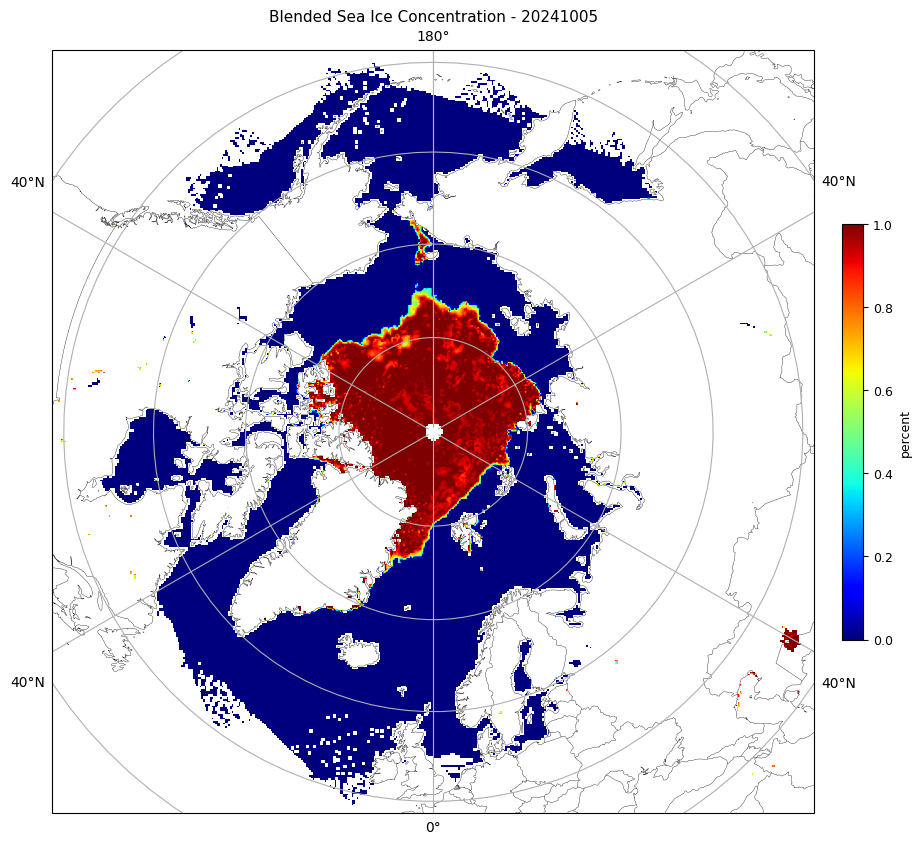

2024-10-08 16:52:13 - Saving PNG  /content/drive/MyDrive/ColabNotebooks/JPSS_SIC/Output_L3/20241005_Blended_AMSR2VIIRS_SIC_arctic.png


In [ ]:
# Verify data file exists
if not os.path.exists(f'{Filename}'):
   sys.exit(f'{Filename} does not exist')

# Determine data type and call its procedure
if Filename.find('JRR-IceConcentration', 0) != -1:  # CLASS
   # Verify L2 output directory exists
   if not os.path.isdir(f'{Out_dir_L2}'):
      sys.exit(f'Output directory {Out_dir_L2} does not exist')
   SIC_L2(Domain, f'{Filename}')

elif Filename.find('Blended_', 0) != -1:  # SSEC/GINA
   # Verify L3 output directory exists
   if not os.path.isdir(f'{Out_dir_L3}'):
      sys.exit(f'Output directory {Out_dir_L3} does not exist')
   print('calling SIC_L3', Domain, Filename)
   SIC_L3(Domain, f'{Filename}')

elif Filename.find('nesdis_blendedsic_nhem_daily_', 0) != -1:  # PolarWatch
   # Verify L3 output directory exists
   if not os.path.isdir(f'{Out_dir_L3}'):
      sys.exit(f'Output directory {Out_dir_L3} does not exist')
   print('calling SIC_L3', Domain, Filename)
   SIC_L3(Domain, f'{Filename}')

elif Filename.find('Polar-AMSR2VIIRSBLEND_', 0) != -1:  # PolarWatch
   # Verify L3 output directory exists
   if not os.path.isdir(f'{Out_dir_L3}'):
      sys.exit(f'Output directory {Out_dir_L3} does not exist')
   print('calling SIC_L3', Domain, Filename)
   SIC_L3(Domain, f'{Filename}')

else:
   sys.exit('File must be: Blend or ????')
###############################################################################